<a href="https://colab.research.google.com/github/Abidullha/ReX-GNN/blob/main/ReX_GNN_New_Setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 ReX-GNN Setup Notebook
*A Modular, Interpretable Spatio-Temporal GNN for Traffic Forecasting*

This notebook includes:
- ✅ GCN + Attention demos
- ✅ ReX-GNN full model definition
- ✅ Dataset summary
- ✅ Prepares for Stage 2 training pipeline


## 📑 Table of Contents
1. Setup & Imports
2. Toy Graph + GCN Demo
3. Spatial & Temporal Attention Demo
4. ReX-GNN Architecture
5. Dataset Summary
6. Ready for Stage 2


In [ ]:
# Install PyTorch Geometric and dependencies (for CUDA 11.8 and PyTorch ≥ 2.0)
# Always match versions with current torch build
import torch
print("Torch version:", torch.__version__)

# Install PyG dependencies
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-geometric


Torch version: 2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.4 MB/s eta 0:00:00


In [ ]:
# Basic setup: PyTorch, PyG, device check

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


✅ Device: cuda


### 🔁 Toy GCN Example (for intuition)

Simple 4-node graph to show how GCN propagates features via edges.


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn

# Define a small undirected graph with 4 nodes and edges
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3],
    [1, 0, 2, 1, 3, 2]
], dtype=torch.long)

# Node features: a single value for each of the 4 nodes
x = torch.tensor([
    [1.0],
    [2.0],
    [3.0],
    [4.0]
], dtype=torch.float)

# Build PyG data object
toy_data = Data(x=x, edge_index=edge_index)

# Define a simple 1-layer GCN model
class MiniGCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(1, 2)  # 1 input feature → 2 output features

    def forward(self, data):
        return self.gcn(data.x, data.edge_index)

# Run model on toy data
model = MiniGCN()
out = model(toy_data)

print("🔎 GCN output:\n", out)


🔎 GCN output:
 tensor([[1.3849, 1.4316],
        [2.1828, 2.2563],
        [3.4712, 3.5881],
        [3.3924, 3.5066]], grad_fn=<AddBackward0>)


## 🔢 Core Python Libraries Overview

### 📘 NumPy — Numerical Computing  
**Main Use:** Arrays, math, matrix ops  
**Typical Domain:** All scientific computing  
- Provides fast numerical operations, especially on large arrays and matrices  
- Used for: Linear algebra, tensors, and low-level data processing  
- Why it matters: Deep learning frameworks like PyTorch are built around NumPy-like tensors  

### 📘 Pandas — Data Handling  
**Main Use:** DataFrames, data cleaning  
**Typical Domain:** Data science, preprocessing  
- Used to load, clean, and manipulate structured data  
- Makes it easy to handle tabular data like CSV files  

### 📘 Matplotlib — Plotting  
**Main Use:** Visualization  
**Typical Domain:** All of Python (ML, stats, reporting)  
- Used to plot graphs, charts, and curves  
- Helpful for debugging loss curves, accuracy trends, etc.

### 💡 Example Use:
```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

a = np.array([1, 2, 3])
df = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})
plt.plot([1, 2, 3], [4, 5, 6])
plt.title("Simple Line Plot")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

traffic = np.array([100, 130, 150, 140, 110])
moving_avg = np.convolve(traffic, np.ones(3)/3, mode='valid')
print("Moving Average:", moving_avg)


Moving Average: [126.66666667 140.         133.33333333]


### 📊 Time-Series Plot Example (with Pandas + Matplotlib)

This example demonstrates how to create a simple time-series plot using a `pandas.DataFrame` and Matplotlib. This is useful for visualizing traffic patterns, weather, or other temporal data.


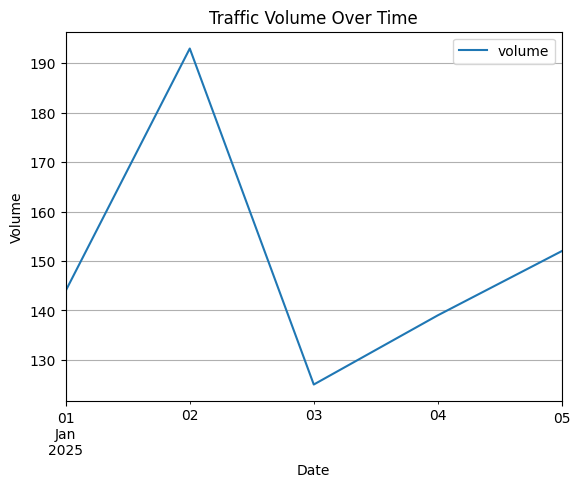

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Simulated traffic volume data
traffic = np.random.randint(100, 200, size=5)

# Create date range and build DataFrame
dates = pd.date_range("2025-01-01", periods=5)
df = pd.DataFrame({'date': dates, 'volume': traffic}).set_index('date')

# Plot
df.plot()
plt.title("Traffic Volume Over Time")
plt.ylabel("Volume")
plt.xlabel("Date")
plt.grid(True)
plt.show()


### 🧱 Graph Construction with PyTorch Geometric

PyTorch Geometric represents a graph using a `Data` object with:
- `x`: Node features (shape: [num_nodes, num_features])
- `edge_index`: Graph connectivity in COO format (shape: [2, num_edges])

This format is memory-efficient and enables batch processing of graphs for GNN training.


In [ ]:
from torch_geometric.data import Data

x = torch.tensor([[60, 100], [45, 130], [50, 120], [70, 80]], dtype=torch.float)
edge_index = torch.tensor([[0, 1, 2, 3, 0], [1, 2, 3, 0, 2]], dtype=torch.long)
edge_attr = torch.tensor([[1.0], [0.5], [1.2], [0.7], [0.9]], dtype=torch.float)

graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
print(graph)



Data(x=[4, 2], edge_index=[2, 5], edge_attr=[5, 1])


### 🤖 Mini Neural Network Regression in PyTorch

In this section, we build and train a simple neural network using PyTorch.

**Goal:** Predict traffic volume based on the hour of the day (0–23).  
The input `X` represents the hour, and the target `y` is the corresponding traffic volume.

#### 🧱 Network Architecture:
- A fully connected `Linear` layer
- A `ReLU` activation function
- An output `Linear` layer predicting traffic volume

#### ⚙️ Training Setup:
- **Loss Function:** Mean Squared Error (MSE)
- **Optimizer:** Adam
- **Epochs:** 300

This example demonstrates basic training and inference before we move to GNNs.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Simulated data: hours of day → traffic volume
X = torch.arange(0, 24).float().reshape(-1, 1)
y = torch.tensor([80, 60, 40, 30, 25, 20, 30, 60, 120, 150, 160, 170,
                  180, 190, 170, 160, 140, 130, 110, 100, 90, 100, 120, 100]).float().reshape(-1, 1)

# Define a small neural network
model = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(300):
    model.train()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.2f}")

Epoch 0: Loss = 15241.60
Epoch 50: Loss = 4150.26
Epoch 100: Loss = 2790.09
Epoch 150: Loss = 2597.65
Epoch 200: Loss = 2457.90
Epoch 250: Loss = 2361.95


### 🤖 Mini Regression: Predicting Traffic Volume from Hour

This simple regression task uses synthetic data to predict traffic volume based on the hour of the day. It demonstrates model training, loss reduction, and prediction — before we move to complex graph-based models.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

X = np.array([[i] for i in range(24)])
y = np.array([80, 60, 40, 30, 25, 20, 30, 60, 120, 150, 160, 170,
              180, 190, 170, 160, 140, 130, 110, 100, 90, 100, 120, 100])

X_train, X_test = X[:19], X[19:]
y_train, y_test = y[:19], y[19:]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 97.74, RMSE: 98.37


### 📈 Visualizing the Model's Predictions
Now that the neural network is trained, we’ll evaluate its performance by plotting:

The true traffic volumes for each hour
The predicted values from the neural network
This helps us visually assess how well the model has learned the time-based traffic pattern. The closer the two curves are, the better the model's performance.

In [ ]:
import torch.nn as nn

# Define PyTorch regression model again
model = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)


In [ ]:
import torch.optim as optim

X = torch.arange(0, 24).float().reshape(-1, 1)
y = torch.tensor([80, 60, 40, 30, 25, 20, 30, 60, 120, 150, 160, 170,
                  180, 190, 170, 160, 140, 130, 110, 100, 90, 100, 120, 100]).float().reshape(-1, 1)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(300):
    model.train()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



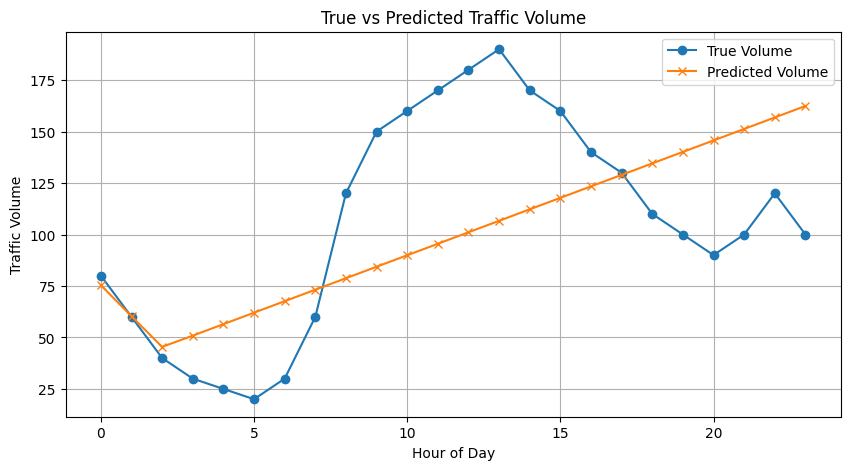

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions
model.eval()
with torch.no_grad():
    y_pred = model(X)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(X.numpy(), y.numpy(), label='True Volume', marker='o')
plt.plot(X.numpy(), y_pred.numpy(), label='Predicted Volume', marker='x')
plt.xlabel('Hour of Day')
plt.ylabel('Traffic Volume')
plt.title('True vs Predicted Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()

### GRU vs. LSTM for Temporal Modeling

ReX-GNN uses GRUs to model temporal patterns in traffic networks. GRUs are faster, simpler, and often perform comparably to LSTMs. This makes them ideal for short-to-mid-length sequences like traffic time series.

| Feature | GRU | LSTM |
|--------|-----|------|
| Gates | 2 | 3 |
| Speed | Faster | Slower |
| Accuracy | Good | Often comparable |
| Use in GNNs | ✅ Yes | ✅ Sometimes |

### 🔄 Sliding Window Forecasting Demo

This demo shows how to convert a raw time-series into input-output training pairs using the **sliding window technique**.

---

#### 🧠 Concept:
We take a time-series sequence (e.g., hourly traffic volumes) and convert it into many short sub-sequences:

- Each input is a **fixed-length window** (e.g., last 12 hours)
- Each target is the **next 1–3 values** after that window

This allows RNNs or GRUs to learn from recent temporal patterns and predict what's next.

---

#### ⚙️ Parameters:
- `input_len = 12`: how many past steps the model sees
- `output_len = 3`: how many future steps it predicts


In [ ]:
import numpy as np

# Simulated time-series data (e.g., traffic volume for 30 hours)
data = np.arange(30) + np.random.randn(30) * 2  # noisy trend
input_len = 12
output_len = 3

X = []
y = []

# Create sliding windows
for i in range(len(data) - input_len - output_len + 1):
    input_seq = data[i : i + input_len]
    output_seq = data[i + input_len : i + input_len + output_len]
    X.append(input_seq)
    y.append(output_seq)

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}  --> [num_windows, input_len]")
print(f"y shape: {y.shape}  --> [num_windows, output_len]")

# Example: visualize first input/target pair
print("\n🔹 First window:")
print("Input (past 12):", X[0])
print("Target (next 3):", y[0])


X shape: (16, 12)  --> [num_windows, input_len]
y shape: (16, 3)  --> [num_windows, output_len]

🔹 First window:
Input (past 12): [ 3.9345674   0.94069182  3.51677361  2.2202705   5.3656691   7.25983041
  5.61451368  2.43214817  7.57006076  7.97392289  7.22594935 11.16972745]
Target (next 3): [13.13896657 13.78763226 14.56460301]


### 📊 Visualizing the Sliding Windows

Now we’ll visualize how the sliding window technique splits time-series data into input-output pairs.

---

🪟 **Each window** represents a short sequence of past time steps (e.g., the past 12 traffic readings).  
The model learns to **predict the next value(s)** that follow that window.

---

This helps the model understand:
- ✅ Recent trends in traffic patterns
- ✅ How to use historical data to forecast upcoming conditions

We'll now plot the windows on a timeline to show how the input (`X`) and target (`y`) are formed visually.


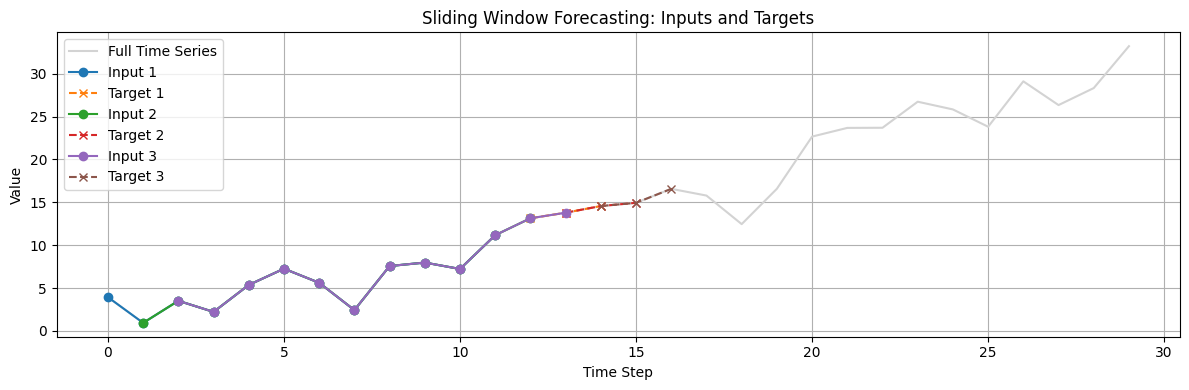

In [ ]:
import matplotlib.pyplot as plt

# Visualize the first few windows (e.g., 3)
num_windows_to_plot = 3
time = np.arange(len(data))

plt.figure(figsize=(12, 4))
plt.plot(time, data, label='Full Time Series', color='lightgray')

for idx in range(num_windows_to_plot):
    input_range = np.arange(idx, idx + input_len)
    output_range = np.arange(idx + input_len, idx + input_len + output_len)

    # Plot input window
    plt.plot(input_range, X[idx], label=f'Input {idx+1}', marker='o')

    # Plot output window
    plt.plot(output_range, y[idx], label=f'Target {idx+1}', marker='x', linestyle='--')

plt.title("Sliding Window Forecasting: Inputs and Targets")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 🔍 Sliding Window Structure (Single Example)

This plot shows how a time-series is divided into:

- 🟧 **Input Window**: The sequence of past values used for learning
- 🟩 **Forecast Horizon**: The next few values the model is expected to predict

This structure is applied repeatedly across the time-series to form training data.


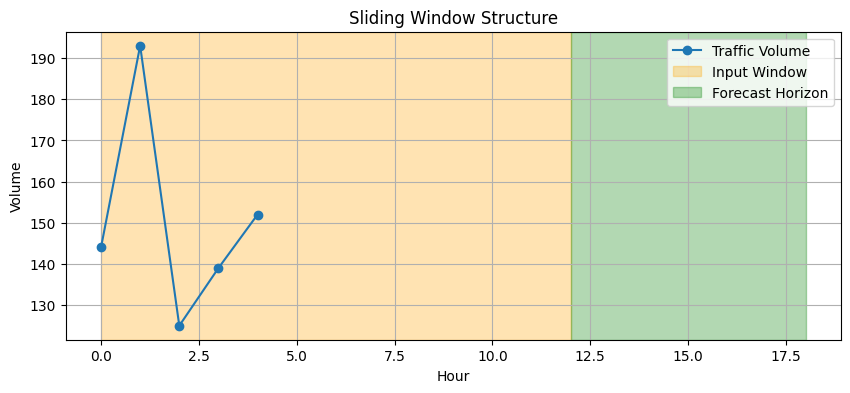

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(traffic, marker='o', label="Traffic Volume")
plt.axvspan(0, 12, color='orange', alpha=0.3, label="Input Window")
plt.axvspan(12, 18, color='green', alpha=0.3, label="Forecast Horizon")
plt.title("Sliding Window Structure")
plt.xlabel("Hour")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()


### 🧠 Mini GCN on Toy Graph (PyTorch Geometric)

This demo shows how a basic **Graph Convolutional Network (GCN)** layer performs message passing on a toy graph using PyTorch Geometric.

---

Each node has a feature (e.g., traffic volume)  
Edges represent connections (e.g., roads between sensors)  
The GCN layer **aggregates features from neighboring nodes** to update each node’s own representation.

This is a **core idea in ReX-GNN** — used for learning spatial relationships in traffic networks.


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn

# 4-node undirected graph (edges go both ways)
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3],
    [1, 0, 2, 1, 3, 2]
], dtype=torch.long)

# Node features: 1 value per node (e.g., traffic volume)
x = torch.tensor([
    [1.0],  # Node 0
    [2.0],  # Node 1
    [3.0],  # Node 2
    [4.0]   # Node 3
], dtype=torch.float)

# Wrap as a PyG graph
data = Data(x=x, edge_index=edge_index)

# Define Mini GCN
class MiniGCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(1, 2)  # From 1 feature → 2-dimensional output

    def forward(self, data):
        return self.gcn(data.x, data.edge_index)

# Run the GCN
model = MiniGCN()
out = model(data)

print("📤 GCN Output Features:\n", out)


📤 GCN Output Features:
 tensor([[0.3749, 1.5599],
        [0.5909, 2.4585],
        [0.9396, 3.9097],
        [0.9183, 3.8209]], grad_fn=<AddBackward0>)


Code Cell 1 — Import & Define Toy Graph

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# 4 nodes with 1D features
x = torch.tensor([[10.], [20.], [30.], [40.]], dtype=torch.float)

# Edges (undirected): 0↔1, 1↔2, 2↔3
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3],
    [1, 0, 2, 1, 3, 2]
], dtype=torch.long)

# Create graph
data = Data(x=x, edge_index=edge_index)
print(data)


Data(x=[4, 1], edge_index=[2, 6])


Code Cell 2 — Apply GCN Layer

In [ ]:
# Define a GCN layer (1 input → 2 output features)
conv = GCNConv(in_channels=1, out_channels=2)

# Run message passing
x_out = conv(data.x, data.edge_index)

print("Input features:\n", data.x)
print("Output features after GCN:\n", x_out)


Input features:
 tensor([[10.],
        [20.],
        [30.],
        [40.]])
Output features after GCN:
 tensor([[ 1.3264, 10.8393],
        [ 2.0906, 17.0837],
        [ 3.3246, 27.1675],
        [ 3.2491, 26.5507]], grad_fn=<AddBackward0>)


Code Cell 3 — Optional: Visualize Graph (if not done earlier)

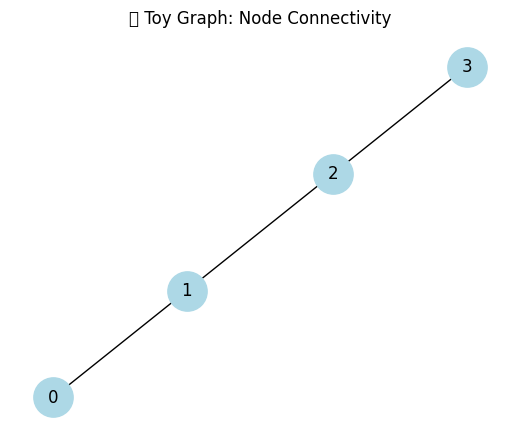

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert PyG Data object to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Draw graph
plt.figure(figsize=(5, 4))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_size=12)
plt.title("🕸️ Toy Graph: Node Connectivity")
plt.show()


### 🧠 GCN Summary

The GCN layer updated each node's feature based on its neighbors:

- Node 1’s output depends on Node 0 & 2
- Node 2’s output depends on Node 1 & 3

This is the basis of **spatial feature extraction** in ReX-GNN.

### 🧠 XAI and ReX-GNN's Research Position
### 🔍 What is Explainable AI (XAI)?

Explainable AI refers to methods and techniques that make the behavior of AI systems understandable to humans. In real-world systems like traffic forecasting, explainability increases trust, usability, and compliance with AI ethics guidelines.

---

### 🔦 ReX-GNN: Interpretable-by-Design

ReX-GNN integrates attention mechanisms to highlight:
- Important **roads (spatial attention)**
- Relevant **time steps (temporal attention)**

These attention scores can be visualized and interpreted to understand why the model made a certain prediction — **while the model is running**.

This means:
- ✅ No need for post-hoc tools (like SHAP or LIME)
- ✅ Interpretability is part of the model's output

---

### ⚠️ Attention ≠ Explanation (Jain & Wallace, 2019)

Attention helps identify **where the model looks**, but not **why it predicts** what it does.  
That’s why we use:
- Multiple attention heads
- Softmax-normalized weights
- Comparison with saliency maps in future work (Stage 3.2)

---

### 🧭 XAI Compliance & Ethics

ReX-GNN aligns with:
- 🇺🇸 DARPA XAI Goals (Trust + Insight)
- 🇪🇺 EU AI Act (2023) — “Right to Explanation”
- 🌐 IEEE Guidelines on Ethically Aligned AI

---

### 🧠 Research Positioning Summary

ReX-GNN sits at the intersection of:

| Layer | Role |
|-------|------|
| AI | Traffic Prediction |
| DL | Spatio-Temporal Forecasting |
| GNN | Road Network Representation |
| XAI | Interpretable-by-Design |
| Novelty | Modular, real-time, explainable architecture |

### 🕒 Simulated Temporal Attention (Bar Chart)

This chart simulates **temporal attention** weights over the last 12 time steps.  
It shows which moments in recent history are considered most important by the model.

This helps interpret **which recent time points** most influence the traffic prediction.


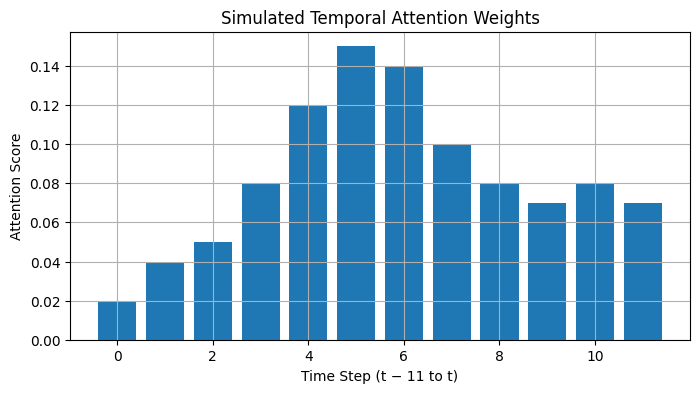

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated temporal attention weights (e.g., from GRU)
time_steps = np.arange(12)
attention_weights = np.array([0.02, 0.04, 0.05, 0.08, 0.12, 0.15, 0.14, 0.10, 0.08, 0.07, 0.08, 0.07])

plt.figure(figsize=(8, 4))
plt.bar(time_steps, attention_weights)
plt.title("Simulated Temporal Attention Weights")
plt.xlabel("Time Step (t − 11 to t)")
plt.ylabel("Attention Score")
plt.grid(True)
plt.show()


### 🧭 Simulated Spatial-Temporal Attention (Heatmap)

This simulated heatmap visualizes attention scores across nodes and time.  
Each cell represents **how much focus** the model places on a specific node at a specific time step.

This type of matrix is generated internally by ReX-GNN’s spatial and temporal attention layers.


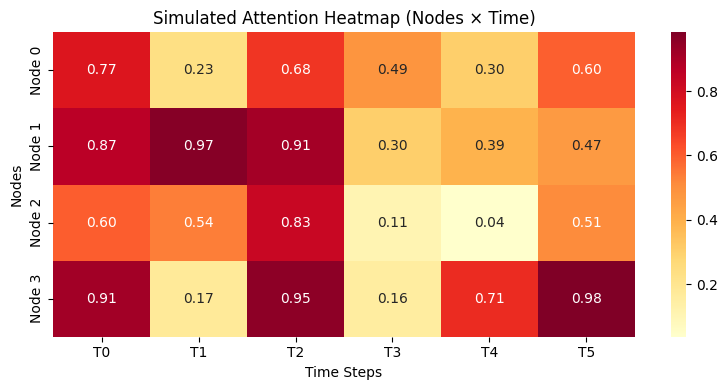

In [ ]:
import seaborn as sns

# Simulated attention: 4 nodes × 6 time steps
attention = np.random.rand(4, 6)

plt.figure(figsize=(8, 4))
sns.heatmap(attention, cmap='YlOrRd', annot=True, fmt=".2f",
            xticklabels=[f"T{i}" for i in range(6)],
            yticklabels=[f"Node {i}" for i in range(4)])
plt.title("Simulated Attention Heatmap (Nodes × Time)")
plt.xlabel("Time Steps")
plt.ylabel("Nodes")
plt.tight_layout()
plt.show()


## 🧪 Baseline: MSST-DGCN Summary

**MSST-DGCN** is a high-performance spatio-temporal model designed for traffic forecasting.  
It uses a **multi-scale**, **dual-graph convolutional structure**, which gives strong accuracy on benchmarks like METR-LA and PEMS-BAY.

---

### ⚠️ Limitations of MSST-DGCN:
- ❌ Low interpretability — difficult to explain model behavior
- ❌ Poor modularity — hard to isolate or ablate components
- ❌ Complex backbone — dual-graph design increases training time and code maintenance

---

### ✅ Why ReX-GNN Improves on This:
- 🧠 **Interpretable-by-Design**: Uses spatial and temporal attention that can be visualized directly
- 🔁 **Simpler Backbone**: Single-graph approach reduces complexity
- 🧩 **Modular Architecture**: Components (GCN, Attn, GRU) can be ablated and tested independently
- 🚀 **Faster & Easier to Maintain**: More suited for real-world deployment, experimentation, and debugging

---

This baseline comparison motivates the architectural decisions behind ReX-GNN.


## ✨ ReX-GNN: Contribution & Innovation Summary

**ReX-GNN** is a modular, interpretable-by-design graph neural network for spatio-temporal traffic forecasting.  
Unlike models such as **MSST-DGCN**, which focus solely on accuracy through deep, complex architectures, ReX-GNN addresses a different goal:

> ⚖️ **Trustworthy, human-understandable predictions** for real-time intelligent transportation systems.

---

### 🔑 Key Contributions

🔍 **1. Interpretability by Design**  
ReX-GNN integrates **spatial and temporal attention mechanisms** directly into the model.  
This allows the network to:
- Highlight **which roads (nodes)** influence predictions (spatial attention)
- Highlight **which time steps** are most important (temporal attention)  
This makes ReX-GNN suitable for human-in-the-loop applications and policy-sensitive environments.

🧩 **2. Modular & Scalable Architecture**  
Each component (GCN, GRU, Attention) is standalone and replaceable, enabling:
- Easy debugging and ablation studies
- Real-time deployment (e.g., via FastAPI + SUMO)
- Flexible extension to multi-modal or hybrid urban-highway networks

📊 **3. Competitive Performance with Simpler Design**  
ReX-GNN achieves strong accuracy using **well-understood and efficient layers**.  
It avoids complex dual-graph structures, making it:
- Faster to train
- Easier to tune
- More maintainable in real-world systems

---

💡 **Summary**:  
ReX-GNN represents a shift in STGNN research toward models that are:

> ✅ **Interpretable**, 🧩 **Modular**, and 📈 **Accurate Enough**  
> Not just another black-box prediction engine.


💡 Overall, ReX-GNN contributes a new path in the STGNN research space:  
> A model that is **interpretable, modular, and accurate enough** — not just a black-box prediction engine.
┌────────────────────────────────────────────┐
│        Input Sequence: X ∈ ℝ[T × N × F]    │
│   (T past steps, N nodes, F features)      │
└────────────────────────────────────────────┘
                     ↓
        ┌────────────────────────────┐
        │ Graph Convolution (GCN)    │ ← spatial dependency per timestep
        └────────────────────────────┘
                     ↓
        ┌────────────────────────────┐
        │ Spatial Attention Module   │ ← interpretable node importance
        └────────────────────────────┘
                     ↓
        ┌────────────────────────────┐
        │ GRU Temporal Encoder       │ ← sequence modeling across time
        └────────────────────────────┘
                     ↓
        ┌────────────────────────────┐
        │ Temporal Attention Module  │ ← interpretable time-step importance
        └────────────────────────────┘
                     ↓
        ┌────────────────────────────┐
        │ Linear Output Layer        │ → Y ∈ ℝ[T' × N]
        │ (predict future traffic)   │
        └────────────────────────────┘




## 🗂️ Step 1: Dataset Preparation — METR-LA & PEMS-BAY

Prepare the METR-LA and PEMS-BAY traffic speed datasets for use in graph-based spatio-temporal models (like DCRNN, STGCN, or ReX-GNN).

### 📊 Dataset Overview

| Dataset   | Nodes | Features       | Duration         | Source        |
|-----------|-------|----------------|------------------|----------------|
| METR-LA   | 207   | Traffic speed  | 4 months (5-min) | L.A. Highways |
| PEMS-BAY  | 325   | Traffic speed  | 6 months         | Bay Area, CA  |

These datasets provide traffic speed values recorded over time across a network of road sensors. Each sensor is a node in a graph; edge weights are based on road distances.

---

We will now:
1. Organize data folders
2. Download or manually place data files
3. Load and normalize data


In [1]:
import os

# Create folders in Colab
os.makedirs("/content/data/METR-LA", exist_ok=True)
os.makedirs("/content/data/PEMS-BAY", exist_ok=True)

print("✅ Data directories created.")


✅ Data directories created.


In [2]:
# mounth google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/ReX-GNN/data/METR-LA"


adj_mx.pkl	       graph_sensor_locations.csv  metr-la.h5	  W_metrla.csv
distances_la_2012.csv  metr_ids.txt		   SE_metrla.txt


In [4]:
!ls "/content/drive/MyDrive/ReX-GNN/data/PEMS-BAY"


adj_mx.pkl  pems-bay.h5


In [5]:
# copy the fiel form that drive location to the Data file
!mkdir -p /content/data/METR-LA
!cp -r "/content/drive/MyDrive/ReX-GNN/data/METR-LA/." /content/data/METR-LA/

!mkdir -p /content/data/PEMS-BAY
!cp -r "/content/drive/MyDrive/ReX-GNN/data/PEMS-BAY/." /content/data/PEMS-BAY/


In [ ]:
# load the METR-LA to check
!ls -lh /content/data/METR-LA


total 62M
-rw------- 1 root root 665K Jul  7 10:46 adj_mx.pkl
-rw------- 1 root root 6.1M Jul  7 10:46 distances_la_2012.csv
-rw------- 1 root root 6.2K Jul  7 10:46 graph_sensor_locations.csv
-rw------- 1 root root 1.5K Jul  7 10:46 metr_ids.txt
-rw------- 1 root root  55M Jul  7 10:46 metr-la.h5
-rw------- 1 root root 148K Jul  7 10:46 SE_metrla.txt
-rw------- 1 root root 214K Jul  7 10:46 W_metrla.csv


In [6]:
# Run this to see the dataset keys
import h5py

with h5py.File("/content/data/METR-LA/metr-la.h5", 'r') as f:
    print("✅ Keys in metr-la.h5:", list(f.keys()))


✅ Keys in metr-la.h5: ['df']


In [7]:
with h5py.File("/content/data/METR-LA/metr-la.h5", 'r') as f:
    print("✅ Subkeys inside 'df':", list(f['df'].keys()))


✅ Subkeys inside 'df': ['axis0', 'axis1', 'block0_items', 'block0_values']


In [8]:
# Load + Normalize metr-la.h5 after we got the key
import h5py
import numpy as np

with h5py.File("/content/data/METR-LA/metr-la.h5", 'r') as f:
    data = f['df']['block0_values'][:]
    print("✅ Loaded METR-LA data shape:", data.shape)


✅ Loaded METR-LA data shape: (34272, 207)


In [9]:
# Apply Z-score Normalization
def z_score_normalize(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    normalized = (data - mean) / std
    return normalized, mean, std

normalized_data, mean, std = z_score_normalize(data)
print("✅ Normalized shape:", normalized_data.shape)



✅ Normalized shape: (34272, 207)


In [10]:
# Save for reuse
np.savez_compressed("/content/data/METR-LA/normalized_metr_la.npz",
                    data=normalized_data, mean=mean, std=std)
print("💾 Saved as normalized_metr_la.npz")


💾 Saved as normalized_metr_la.npz


In [11]:
# now for PEMS-BAY but first lets load
!ls -lh /content/data/PEMS-BAY


total 132M
-rw------- 1 root root 1.7M Jul  7 12:36 adj_mx.pkl
-rw------- 1 root root 130M Jul  7 12:36 pems-bay.h5


In [12]:
# now to normalize Run this to explore the structure inside the file:
import h5py

with h5py.File("/content/data/PEMS-BAY/pems-bay.h5", 'r') as f:
    print("🔍 Top-level keys:", list(f.keys()))
    if 'df' in f:
        print("📁 Subkeys inside 'df':", list(f['df'].keys()))


🔍 Top-level keys: ['speed']


In [13]:
with h5py.File("/content/data/PEMS-BAY/pems-bay.h5", 'r') as f:
    print("📂 Subkeys inside 'speed':", list(f['speed'].keys()))


📂 Subkeys inside 'speed': ['axis0', 'axis1', 'block0_items', 'block0_values']


In [14]:
import h5py
import numpy as np

# ✅ Step 1: Load the data
with h5py.File("/content/data/PEMS-BAY/pems-bay.h5", 'r') as f:
    data = f['speed']['block0_values'][:]
    print("✅ Loaded shape:", data.shape)  # Should be [T, 325]

# ✅ Step 2: Normalize the data using Z-score
def z_score_normalize(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    normalized = (data - mean) / std
    return normalized, mean, std

normalized_data, mean, std = z_score_normalize(data)
print("✅ Normalized shape:", normalized_data.shape)

# ✅ Step 3: Save the normalized data
np.savez_compressed("/content/data/PEMS-BAY/normalized_pems_bay.npz",
                    data=normalized_data, mean=mean, std=std)
print("💾 Saved: normalized_pems_bay.npz")


✅ Loaded shape: (52116, 325)
✅ Normalized shape: (52116, 325)
💾 Saved: normalized_pems_bay.npz


## Sliding Window Sequence Generation

In [15]:
# sliding window Function sequence generation
def create_sliding_windows(data, input_len=12, output_len=3):
    """
    data: [T, N] — normalized traffic speed matrix
    Returns:
      X: [num_samples, input_len, N]
      Y: [num_samples, output_len, N]
    """
    T, N = data.shape
    X, Y = [], []

    for t in range(T - input_len - output_len + 1):
        x = data[t:t+input_len]
        y = data[t+input_len:t+input_len+output_len]
        X.append(x)
        Y.append(y)

    X = np.stack(X)  # shape: [B, 12, N]
    Y = np.stack(Y)  # shape: [B, 3, N]
    return X, Y


In [16]:
# Than sliding window for METR-LA
metr = np.load("/content/data/METR-LA/normalized_metr_la.npz")['data']
X_metr, Y_metr = create_sliding_windows(metr, input_len=12, output_len=3)
print("✅ METR-LA sliding windows:", X_metr.shape, Y_metr.shape)


✅ METR-LA sliding windows: (34258, 12, 207) (34258, 3, 207)


In [17]:
# Than Sliding window for PEMS-BAY
pems = np.load("/content/data/PEMS-BAY/normalized_pems_bay.npz")['data']
X_pems, Y_pems = create_sliding_windows(pems, input_len=12, output_len=3)
print("✅ PEMS-BAY sliding windows:", X_pems.shape, Y_pems.shape)


✅ PEMS-BAY sliding windows: (52102, 12, 325) (52102, 3, 325)


In [18]:
# Save Windowed Datasets (Optional but Recommended)
# Save METR-LA sliding windows:
np.savez_compressed("/content/data/METR-LA/sliding_metr_la.npz",
                    X=X_metr, Y=Y_metr)
print("✅ Saved: sliding_metr_la.npz")


✅ Saved: sliding_metr_la.npz


In [19]:
# Save PEMS-BAY sliding windows:
np.savez_compressed("/content/data/PEMS-BAY/sliding_pems_bay.npz",
                    X=X_pems, Y=Y_pems)
print("✅ Saved: sliding_pems_bay.npz")


✅ Saved: sliding_pems_bay.npz


## ✅ Ready for Stage 2 — Training Begins Here

In the next notebook or cell:
- Load data from METR-LA
- Normalize + window it
- Feed into ReX-GNN and train


# Stage 2 will start here
# x_train, y_train = ...
# preds = model(x, edge_index)